In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Set working directory
%cd /content/drive/MyDrive/FDA/

/content/drive/MyDrive/FDA


In [3]:
# Include Libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.dates import DateFormatter

# Overview of the approach:
*  Step 1(Preprocess the data) --> Two datasets "all_accelerometer_data_pids_13.csv" and "clean_tac.zip" have been used for this project. These two datasets are merged based on timestamp and pid. The timestamp values are converted in same units in order to join the datasets.
*  Step 2(Segmentation based on Tac reading) --> For each pid, the data is segmented based on tac reading. Each segment is used to identify ordinal pattern in the data.
*  Step 3(Calculate permutation entropy and complexity) --> The permutation entropy, complexity is calculated using the ordinal patterns for each segment.
*  Step 4(Implement permutation entropy and complexity) --> The permutation entropy and complexity is calculated for each segments/ordinal patterns for each pid.
*  Step 5(Compare permutation entropy, complexity with Tac) --> A classification model is created to compare the intoxication level values calculated using tac reading and permutation entropy/complexity.

# Step 1: Preprocess the data

Create dataframe for each pid, added column for pid value and merged them together to get a single dataframe with all pids with their tac reading.

In [4]:
# Read clean TAC data and add pid in the dataframe
df_bk7610 = pd.read_csv('BK7610_clean_TAC.csv')
df_bk7610['pid']='BK7610'
df_bu4707 = pd.read_csv('BU4707_clean_TAC.csv')
df_bu4707['pid']='BU4707'
df_cc6740 = pd.read_csv('CC6740_clean_TAC.csv')
df_cc6740['pid']='CC6740'
df_dc6359 = pd.read_csv('DC6359_clean_TAC.csv')
df_dc6359['pid']='DC6359'
df_dk3500 = pd.read_csv('DK3500_clean_TAC.csv')
df_dk3500['pid']='DK3500'
df_hv0618 = pd.read_csv('HV0618_clean_TAC.csv')
df_hv0618['pid']='HV0618'
df_jb3156 = pd.read_csv('JB3156_clean_TAC.csv')
df_jb3156['pid']='JB3156'
df_jr8022 = pd.read_csv('JR8022_clean_TAC.csv')
df_jr8022['pid']='JR8022'
df_mc7070 = pd.read_csv('MC7070_clean_TAC.csv')
df_mc7070['pid']='MC7070'
df_mj8002 = pd.read_csv('MJ8002_clean_TAC.csv')
df_mj8002['pid']='MJ8002'
df_pc6771 = pd.read_csv('PC6771_clean_TAC.csv')
df_pc6771['pid']='PC6771'
df_sa0297 = pd.read_csv('SA0297_clean_TAC.csv')
df_sa0297['pid']='SA0297'
df_sf3079 = pd.read_csv('SF3079_clean_TAC.csv')
df_sf3079['pid']='SF3079'
df_cleaned_data = pd.concat([df_bk7610,df_bu4707,df_cc6740,df_dc6359,df_dk3500,df_hv0618,df_jb3156,df_jr8022,df_mc7070,df_mj8002,df_pc6771,df_sa0297,df_sf3079], ignore_index=True)
df_cleaned_data

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493720697,0.001573,BK7610
2,1493721027,0.002144,BK7610
3,1493721357,0.000877,BK7610
4,1493721686,-0.001145,BK7610
...,...,...,...
710,1493797974,0.029049,SF3079
711,1493799820,0.016286,SF3079
712,1493801652,0.004243,SF3079
713,1493803481,-0.001995,SF3079


Load all accelerometer data in a dataframe.

In [5]:
#Read all accelerometer data and import from CSV
df_all_acc_data = pd.read_csv('all_accelerometer_data_pids_13.csv')
df_all_acc_data

,time,pid,x,y,z
0,0,JB3156,0.000000,0.000000,0.000000
1,0,CC6740,0.000000,0.000000,0.000000
2,1493733882409,SA0297,0.075800,0.027300,-0.010200
3,1493733882455,SA0297,-0.035900,0.079400,0.003700
4,1493733882500,SA0297,-0.242700,-0.086100,-0.016300
...,...,...,...,...,...
14057562,1493829248196,CC6740,-0.133956,0.124726,-0.010736
14057563,1493829248220,CC6740,-0.100764,0.180872,0.046449
14057564,1493829248245,CC6740,-0.131853,0.195934,0.181088
14057565,1493829248270,CC6740,-0.149704,0.194482,0.202393


Convert all accelerometer reading from miliseconds to seconds in order to join with the tac reading data.

In [6]:
#Changing the all acc data from miliseconds to seconds
df_all_acc_data['time'] = pd.to_datetime(df_all_acc_data['time'] // 1000, unit='s')
#keep cleaned data in seconds
df_cleaned_data['timestamp'] = pd.to_datetime(df_cleaned_data['timestamp'], unit='s')
#Show all acc data after changing the timestamp values from milisecond to second
df_all_acc_data

,time,pid,x,y,z
0,1970-01-01 00:00:00,JB3156,0.000000,0.000000,0.000000
1,1970-01-01 00:00:00,CC6740,0.000000,0.000000,0.000000
2,2017-05-02 14:04:42,SA0297,0.075800,0.027300,-0.010200
3,2017-05-02 14:04:42,SA0297,-0.035900,0.079400,0.003700
4,2017-05-02 14:04:42,SA0297,-0.242700,-0.086100,-0.016300
...,...,...,...,...,...
14057562,2017-05-03 16:34:08,CC6740,-0.133956,0.124726,-0.010736
14057563,2017-05-03 16:34:08,CC6740,-0.100764,0.180872,0.046449
14057564,2017-05-03 16:34:08,CC6740,-0.131853,0.195934,0.181088
14057565,2017-05-03 16:34:08,CC6740,-0.149704,0.194482,0.202393


Merge the Tac reading and accelerometer data using pid and timestamp.

In [7]:
# Perform the merge operation with different column names
merged_df = df_all_acc_data.merge(df_cleaned_data,
                                    left_on=['pid', 'time'],
                                    right_on=['pid', 'timestamp'],
                                    how='inner')
merged_df

,time,pid,x,y,z,timestamp,TAC_Reading
0,2017-05-02 14:14:08,SA0297,0.131200,0.043200,0.003400,2017-05-02 14:14:08,0.032672
1,2017-05-02 14:14:08,SA0297,0.273400,0.119700,0.096800,2017-05-02 14:14:08,0.032672
2,2017-05-02 14:14:08,SA0297,0.151400,0.188600,0.037500,2017-05-02 14:14:08,0.032672
3,2017-05-02 14:14:08,SA0297,-0.091400,0.049600,0.053400,2017-05-02 14:14:08,0.032672
4,2017-05-02 14:14:08,SA0297,-0.793500,-0.518400,0.396700,2017-05-02 14:14:08,0.032672
...,...,...,...,...,...,...,...
6142,2017-05-03 11:09:10,CC6740,0.012896,-0.013732,0.604185,2017-05-03 11:09:10,0.005040
6143,2017-05-03 11:09:10,CC6740,-0.006422,0.023981,0.565886,2017-05-03 11:09:10,0.005040
6144,2017-05-03 11:09:10,CC6740,0.012401,0.004974,0.565885,2017-05-03 11:09:10,0.005040
6145,2017-05-03 11:09:10,CC6740,0.012559,0.005315,0.470111,2017-05-03 11:09:10,0.005040


In [8]:
#As both time and timestamp columns are same, dropping timestamp column to keep only one
merged_df = merged_df.drop('timestamp', axis=1)
merged_df

,time,pid,x,y,z,TAC_Reading
0,2017-05-02 14:14:08,SA0297,0.131200,0.043200,0.003400,0.032672
1,2017-05-02 14:14:08,SA0297,0.273400,0.119700,0.096800,0.032672
2,2017-05-02 14:14:08,SA0297,0.151400,0.188600,0.037500,0.032672
3,2017-05-02 14:14:08,SA0297,-0.091400,0.049600,0.053400,0.032672
4,2017-05-02 14:14:08,SA0297,-0.793500,-0.518400,0.396700,0.032672
...,...,...,...,...,...,...
6142,2017-05-03 11:09:10,CC6740,0.012896,-0.013732,0.604185,0.005040
6143,2017-05-03 11:09:10,CC6740,-0.006422,0.023981,0.565886,0.005040
6144,2017-05-03 11:09:10,CC6740,0.012401,0.004974,0.565885,0.005040
6145,2017-05-03 11:09:10,CC6740,0.012559,0.005315,0.470111,0.005040


Check the number of records by pid.

In [9]:
#Count records by pid
record_counts = merged_df.groupby('pid')['pid'].count().reset_index(name='record_count')
print(record_counts)

       pid  record_count
0   BK7610           674
1   BU4707           237
2   CC6740           831
3   DC6359           304
4   DK3500           637
5   HV0618           600
6   JB3156           720
7   JR8022           119
8   MC7070           191
9   MJ8002           320
10  PC6771           762
11  SA0297           396
12  SF3079           356


Calculate the resultant vector(magnitude across all directions i.e. x,y,z).

In [10]:
#Calculate resultant vector in x,y,z direction
merged_df['resultant_vec'] = np.sqrt(merged_df['x']**2 + merged_df['y']**2 + merged_df['z']**2)
merged_df

,time,pid,x,y,z,TAC_Reading,resultant_vec
0,2017-05-02 14:14:08,SA0297,0.131200,0.043200,0.003400,0.032672,0.138171
1,2017-05-02 14:14:08,SA0297,0.273400,0.119700,0.096800,0.032672,0.313761
2,2017-05-02 14:14:08,SA0297,0.151400,0.188600,0.037500,0.032672,0.244741
3,2017-05-02 14:14:08,SA0297,-0.091400,0.049600,0.053400,0.032672,0.116900
4,2017-05-02 14:14:08,SA0297,-0.793500,-0.518400,0.396700,0.032672,1.027498
...,...,...,...,...,...,...,...
6142,2017-05-03 11:09:10,CC6740,0.012896,-0.013732,0.604185,0.005040,0.604479
6143,2017-05-03 11:09:10,CC6740,-0.006422,0.023981,0.565886,0.005040,0.566430
6144,2017-05-03 11:09:10,CC6740,0.012401,0.004974,0.565885,0.005040,0.566042
6145,2017-05-03 11:09:10,CC6740,0.012559,0.005315,0.470111,0.005040,0.470309


Create sample dataframe to contain relevant columns only.

In [11]:
df_sample = pd.DataFrame ({'pid':merged_df['pid'], 'time':merged_df['time'], 'resultant_vec':merged_df['resultant_vec'],'tac':merged_df['TAC_Reading']})
df_sample

,pid,time,resultant_vec,tac
0,SA0297,2017-05-02 14:14:08,0.138171,0.032672
1,SA0297,2017-05-02 14:14:08,0.313761,0.032672
2,SA0297,2017-05-02 14:14:08,0.244741,0.032672
3,SA0297,2017-05-02 14:14:08,0.116900,0.032672
4,SA0297,2017-05-02 14:14:08,1.027498,0.032672
...,...,...,...,...
6142,CC6740,2017-05-03 11:09:10,0.604479,0.005040
6143,CC6740,2017-05-03 11:09:10,0.566430,0.005040
6144,CC6740,2017-05-03 11:09:10,0.566042,0.005040
6145,CC6740,2017-05-03 11:09:10,0.470309,0.005040


Select one pid for testing purpose.

In [12]:
df_selected_pid= df_sample[df_sample['pid']=='PC6771']
df_selected_pid

,pid,time,resultant_vec,tac
22,PC6771,2017-05-02 14:49:03,0.003878,0.069712
23,PC6771,2017-05-02 14:49:03,0.004416,0.069712
24,PC6771,2017-05-02 14:49:03,0.003286,0.069712
25,PC6771,2017-05-02 14:49:03,0.004089,0.069712
26,PC6771,2017-05-02 14:49:03,0.004105,0.069712
...,...,...,...,...
5858,PC6771,2017-05-03 09:33:00,0.027072,-0.004448
5859,PC6771,2017-05-03 09:33:00,0.020726,-0.004448
5860,PC6771,2017-05-03 09:33:00,0.019572,-0.004448
5861,PC6771,2017-05-03 09:33:00,0.028520,-0.004448


Plot time series graph for resultant acceleration and tac for a single pid.

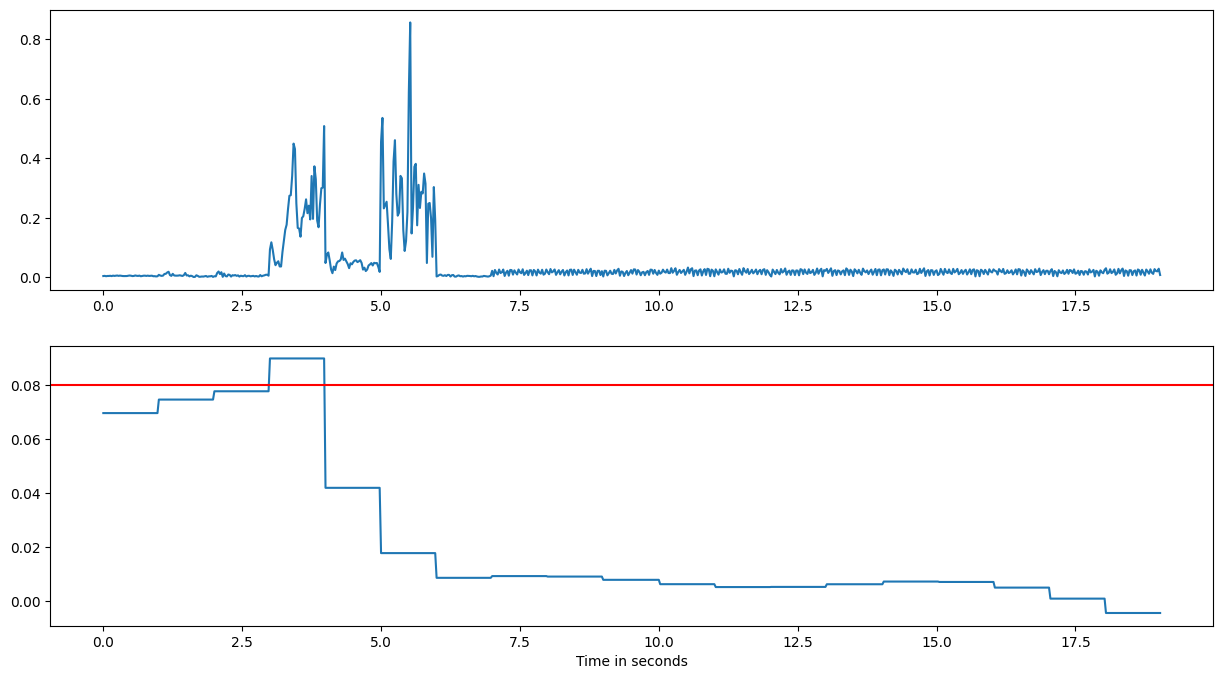

In [13]:
#Plot the data for one pid
#correct the acc reading to show 1 reading per sec
time = np.arange(df_selected_pid['resultant_vec'].size)/40
fig,ax = plt.subplots(2,figsize=(15,8))
plt.xlabel("Time in seconds")

ax[0].plot(time,"resultant_vec",data=df_selected_pid)
ax[1].plot(time,"tac",data=df_selected_pid)
ax[1].axhline(y=0.08,color='r',linestyle='-')
plt.show()

# Step 2 : Segmentation based on Tac values

Segment the dataset based on TAC reading. To do this, the data is sorted based pid and time. A new segment is created whenever the tac changes for a pid. The segment number is stored in a new column segment_id. The dataframe name is updated as df_sample_segmented.

In [14]:
# Ensure your DataFrame is sorted by 'pid' and 'time'
df_sample_segmented = df_sample.sort_values(by=['pid', 'time'])

# Create a boolean Series that marks where 'tac' changes
tac_changes = df_sample_segmented.groupby('pid')['tac'].transform(lambda x: x != x.shift())

# Convert boolean Series to integers and then use cumsum to create segment IDs
df_sample_segmented['segment_id'] = tac_changes.astype(int).cumsum()

# To restart segment_id numbering for each pid
df_sample_segmented['segment_id'] = df_sample_segmented.groupby('pid')['segment_id'].transform(lambda x: x - x.min())

Check segmentation for one pid.

In [15]:
df_sample_segmented[df_sample_segmented['pid']=='PC6771']

,pid,time,resultant_vec,tac,segment_id
22,PC6771,2017-05-02 14:49:03,0.003878,0.069712,0
23,PC6771,2017-05-02 14:49:03,0.004416,0.069712,0
24,PC6771,2017-05-02 14:49:03,0.003286,0.069712,0
25,PC6771,2017-05-02 14:49:03,0.004089,0.069712,0
26,PC6771,2017-05-02 14:49:03,0.004105,0.069712,0
...,...,...,...,...,...
5858,PC6771,2017-05-03 09:33:00,0.027072,-0.004448,18
5859,PC6771,2017-05-03 09:33:00,0.020726,-0.004448,18
5860,PC6771,2017-05-03 09:33:00,0.019572,-0.004448,18
5861,PC6771,2017-05-03 09:33:00,0.028520,-0.004448,18


Check segments by Pid and Tac. Now, each pid and tac combination contains ~40 segments.

In [16]:
# Grouping by 'pid' and 'tac', and then counting the number of 'segment_id' for each group
segment_counts = df_sample_segmented.groupby(['pid', 'tac'])['segment_id'].count().reset_index(name='segment_counts')

# Printing the result
print(segment_counts)

        pid       tac  segment_counts
0    BK7610  0.041689              40
1    BK7610  0.046559              40
2    BK7610  0.050424              40
3    BK7610  0.065357              39
4    BK7610  0.065953              40
..      ...       ...             ...
157  SF3079  0.107148              40
158  SF3079  0.130305              40
159  SF3079  0.135561              39
160  SF3079  0.159026              39
161  SF3079  0.171436              40

[162 rows x 3 columns]


# Step 3: Calculate Ordinal Pattern, Shannon Entropy, Permutation Entropy and Complexity

Create a fundtion to find ordinal pattern.

In [17]:
#Calculate ordinal pattern
from itertools import permutations

def ordinal_pattern_segment(x, dim):
    ordinal_numbers = list(range(dim))
    possible_patterns = list(permutations(ordinal_numbers))
    pattern_counts = np.zeros(len(possible_patterns), dtype=int)

    for i in range(len(x) - dim + 1):
        temp = x[i:i+dim]
        sorted_indices = tuple(np.argsort(temp))
        pattern_index = possible_patterns.index(sorted_indices)
        pattern_counts[pattern_index] += 1

    return pattern_counts

Store the pattern count in a series based on pid and segment id.

In [18]:
#Apply ordinal pattern for each participant each segment
dim = 3  # Embedding dimension

# Group by both 'pid' and 'segment_id', then apply the function
pattern_counts_by_pid_segment = df_sample_segmented.groupby(['pid', 'segment_id'])['resultant_vec'].apply(lambda x: ordinal_pattern_segment(x, dim))

# Now, pattern_counts_by_pid_segment is a Series with a MultiIndex ('pid', 'segment_id')
# Each entry contains the ordinal pattern counts for a segment of a participant
print(pattern_counts_by_pid_segment)

pid     segment_id
BK7610  0              [8, 5, 3, 5, 4, 12]
        1              [4, 8, 10, 3, 5, 8]
        2              [11, 4, 5, 7, 8, 3]
        3             [12, 2, 3, 4, 6, 11]
        4              [13, 3, 3, 4, 4, 9]
                              ...         
SF3079  4              [10, 4, 3, 9, 7, 5]
        5               [7, 5, 4, 8, 6, 7]
        6               [4, 7, 8, 4, 6, 9]
        7              [9, 6, 5, 4, 3, 10]
        8             [12, 2, 2, 5, 6, 10]
Name: resultant_vec, Length: 162, dtype: object


Create a function to calculate shannon entropy.

In [19]:
#Calculate shannon entropy

def s_entropy(prob_dist):
    """
    Computes the Shannon entropy of a probability distribution.

    Parameters:
    - prob_dist: A numpy array representing a probability distribution. Each element must be
                 a probability of the corresponding outcome, and the sum should be 1.

    Returns:
    - entropy: A numeric value representing the Shannon entropy of the distribution.
    """
    # Filter out zero probabilities to avoid log(0) which is undefined
    prob_dist = prob_dist[prob_dist > 0]

    # Calculate Shannon entropy
    entropy = -np.sum(prob_dist * np.log2(prob_dist))

    return entropy


Create a function to calculate permutation entropy.

In [20]:
def permutation_entropy(op):
    """
    Computes the normalized permutation entropy of a given set of ordinal pattern frequencies.

    Parameters:
    - op: Iterable (list or np.array) of counts of each ordinal pattern.

    Returns:
    - Normalized permutation entropy as a float, ranging from 0 to 1.
    """
    # Ensure op is a numpy array for vectorized operations
    op = np.array(op, dtype=float)

    # Normalize the pattern counts to probabilities
    probabilities = op / np.sum(op)

    # Calculate Shannon entropy of the probability distribution using s_entropy
    shannon_entropy = s_entropy(probabilities)

    # Calculate maximum possible entropy given the number of unique patterns
    num_patterns = len(op)
    max_entropy = np.log2(num_patterns)

    # Normalize the Shannon entropy by the maximum possible entropy
    normalized_permutation_entropy = shannon_entropy / max_entropy

    return normalized_permutation_entropy

Create a function to calculate complexity.

In [21]:
#Calculate complexity

def complexity(op):
    """
    Computes the complexity of a time series using its ordinal patterns.

    Parameters:
    - op: Array of ordinal pattern counts from a time series.

    Returns:
    - Comp_JS: The computed complexity measure based on Jensen-Shannon divergence and permutation entropy.
    """
    # Calculate permutation entropy (pe) from the ordinal pattern counts
    pe = permutation_entropy(op)

    # Calculate the normalizing constant (Q_o) components
    constant1 = (0.5 + ((1 - 0.5) / len(op))) * np.log(0.5 + ((1 - 0.5) / len(op)))
    constant2 = ((1 - 0.5) / len(op)) * np.log((1 - 0.5) / len(op)) * (len(op) - 1)
    constant3 = 0.5 * np.log(len(op))

    # Compute Q_o using the calculated components
    Q_o = -1 / (constant1 + constant2 + constant3)

    # Normalize the ordinal pattern counts to probabilities
    temp_op_prob = np.divide(op, sum(op))

    # Adjust the ordinal pattern probabilities and create a mixed distribution for JS divergence calculation
    temp_op_prob2 = (0.5 * temp_op_prob) + (0.5 * (1 / len(op)))

    # Calculate Jensen-Shannon divergence
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))

    # Calculate the final complexity measure (Comp_JS)
    Comp_JS = Q_o * JSdivergence * pe

    return Comp_JS

# Step 4 : Implement Permuation Entropy and Complexity for each segments

Calculate permutation entropy and complexity for each pid/segment combination(ordinal patterns). Store these results in dictionaries.

In [22]:
#Calculate Permuation Entropy and Complexity for each segments
# Initialize dictionaries to store the results
permutation_entropy_results = {}
complexity_results = {}

#Iterate over each entry in pattern_counts_by_pid_segment to calculate entropy and complexity
for index, pattern_counts in pattern_counts_by_pid_segment.items():
    pid, segment_id = index  # Extract pid and segment_id from the MultiIndex
    # Calculate permutation entropy
    pe = permutation_entropy(pattern_counts)
    # Calculate complexity
    comp = complexity(pattern_counts)

    # Store the results
    permutation_entropy_results[index] = pe
    complexity_results[index] = comp


In [23]:
print(permutation_entropy_results)

{('BK7610', 0): 0.9384427636873285, ('BK7610', 1): 0.9552967307039063, ('BK7610', 2): 0.9503495825812311, ('BK7610', 3): 0.8967175301700968, ('BK7610', 4): 0.902360862481398, ('BK7610', 5): 0.9100123932767151, ('BK7610', 6): 0.9960197593954816, ('BK7610', 7): 0.9860384480400781, ('BK7610', 8): 0.8509636993690404, ('BK7610', 9): 0.9700057238624978, ('BK7610', 10): 0.8765500685215617, ('BK7610', 11): 0.8873833515146428, ('BK7610', 12): 0.986238261487513, ('BK7610', 13): 0.905153120223003, ('BK7610', 14): 0.8509636993690404, ('BK7610', 15): 0.8842715289028856, ('BK7610', 16): 0.9457430857289653, ('BU4707', 0): 0.8941551447239732, ('BU4707', 1): 0.9542728714118537, ('BU4707', 2): 0.8910943691742046, ('BU4707', 3): 0.9372323588006967, ('BU4707', 4): 0.9692935913627072, ('BU4707', 5): 0.9328323814477827, ('CC6740', 0): 0.863173161693871, ('CC6740', 1): 0.9700057238624978, ('CC6740', 2): 0.9839330922873069, ('CC6740', 3): 0.9775277211118096, ('CC6740', 4): 0.9745703937213608, ('CC6740', 5): 0

In [24]:
print(complexity_results)

{('BK7610', 0): 0.8999827966160039, ('BK7610', 1): 0.897094273355872, ('BK7610', 2): 0.8980319824493553, ('BK7610', 3): 0.9180891907723376, ('BK7610', 4): 0.909701693539696, ('BK7610', 5): 0.9075053510863645, ('BK7610', 6): 0.8759954452694687, ('BK7610', 7): 0.8818078710284754, ('BK7610', 8): 0.9228388285843803, ('BK7610', 9): 0.8896145949438827, ('BK7610', 10): 0.928815152707199, ('BK7610', 11): 0.930145552998629, ('BK7610', 12): 0.881480178560082, ('BK7610', 13): 0.91510577271964, ('BK7610', 14): 0.9228388285843803, ('BK7610', 15): 0.918012448583421, ('BK7610', 16): 0.9052454194275623, ('BU4707', 0): 0.9177904394253782, ('BU4707', 1): 0.8956530390649207, ('BU4707', 2): 0.9282313868280905, ('BU4707', 3): 0.9080085408625987, ('BU4707', 4): 0.89124950540858, ('BU4707', 5): 0.9047728504555862, ('CC6740', 0): 0.9645389805701998, ('CC6740', 1): 0.8896145949438827, ('CC6740', 2): 0.882734545504837, ('CC6740', 3): 0.8855752320657102, ('CC6740', 4): 0.8875018304976793, ('CC6740', 5): 0.920148

Update the dataframe(df_sample_segmented) to have the values of permutation entropy and complexity.

In [25]:
# Add a new column for permutation entropy in df_sample_segmented
# Initialize with NaN or a placeholder value
df_sample_segmented['permutation_entropy'] = np.nan

# Iterate over the dictionary to update the DataFrame
for (pid, segment_id), entropy in permutation_entropy_results.items():
    df_sample_segmented.loc[(df_sample_segmented['pid'] == pid) & (df_sample_segmented['segment_id'] == segment_id), 'permutation_entropy'] = entropy

# Add a new column for complexity_results in df_sample_segmented
# Initialize with NaN or a placeholder value
df_sample_segmented['complexity'] = np.nan

# Iterate over the dictionary to update the DataFrame
for (pid, segment_id), complexity in complexity_results.items():
    df_sample_segmented.loc[(df_sample_segmented['pid'] == pid) & (df_sample_segmented['segment_id'] == segment_id), 'complexity'] = complexity

df_sample_segmented

,pid,time,resultant_vec,tac,segment_id,permutation_entropy,complexity
62,BK7610,2017-05-02 14:57:26,0.332943,0.065357,0,0.938443,0.899983
63,BK7610,2017-05-02 14:57:26,0.343604,0.065357,0,0.938443,0.899983
64,BK7610,2017-05-02 14:57:26,0.440437,0.065357,0,0.938443,0.899983
65,BK7610,2017-05-02 14:57:26,0.400427,0.065357,0,0.938443,0.899983
66,BK7610,2017-05-02 14:57:26,0.372569,0.065357,0,0.938443,0.899983
...,...,...,...,...,...,...,...
3851,SF3079,2017-05-03 03:15:46,0.136003,0.159026,8,0.892810,0.922106
3852,SF3079,2017-05-03 03:15:46,0.233955,0.159026,8,0.892810,0.922106
3853,SF3079,2017-05-03 03:15:46,0.244065,0.159026,8,0.892810,0.922106
3854,SF3079,2017-05-03 03:15:46,0.166261,0.159026,8,0.892810,0.922106


Plot the permutation entropy, complexity and TAC reading for one pid.

In [26]:
# Filter the DataFrame for a single participant
df_pid = df_sample_segmented[df_sample_segmented['pid'] == 'SF3079']
df_pid

,pid,time,resultant_vec,tac,segment_id,permutation_entropy,complexity
351,SF3079,2017-05-02 16:05:16,0.003561,0.171436,0,0.966295,0.892505
352,SF3079,2017-05-02 16:05:16,0.002090,0.171436,0,0.966295,0.892505
353,SF3079,2017-05-02 16:05:16,0.000548,0.171436,0,0.966295,0.892505
354,SF3079,2017-05-02 16:05:16,0.004627,0.171436,0,0.966295,0.892505
355,SF3079,2017-05-02 16:05:16,0.000860,0.171436,0,0.966295,0.892505
...,...,...,...,...,...,...,...
3851,SF3079,2017-05-03 03:15:46,0.136003,0.159026,8,0.892810,0.922106
3852,SF3079,2017-05-03 03:15:46,0.233955,0.159026,8,0.892810,0.922106
3853,SF3079,2017-05-03 03:15:46,0.244065,0.159026,8,0.892810,0.922106
3854,SF3079,2017-05-03 03:15:46,0.166261,0.159026,8,0.892810,0.922106


<ipython-input-27-e1f6e708c54d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pid['time'] = pd.to_datetime(df_pid['time'])


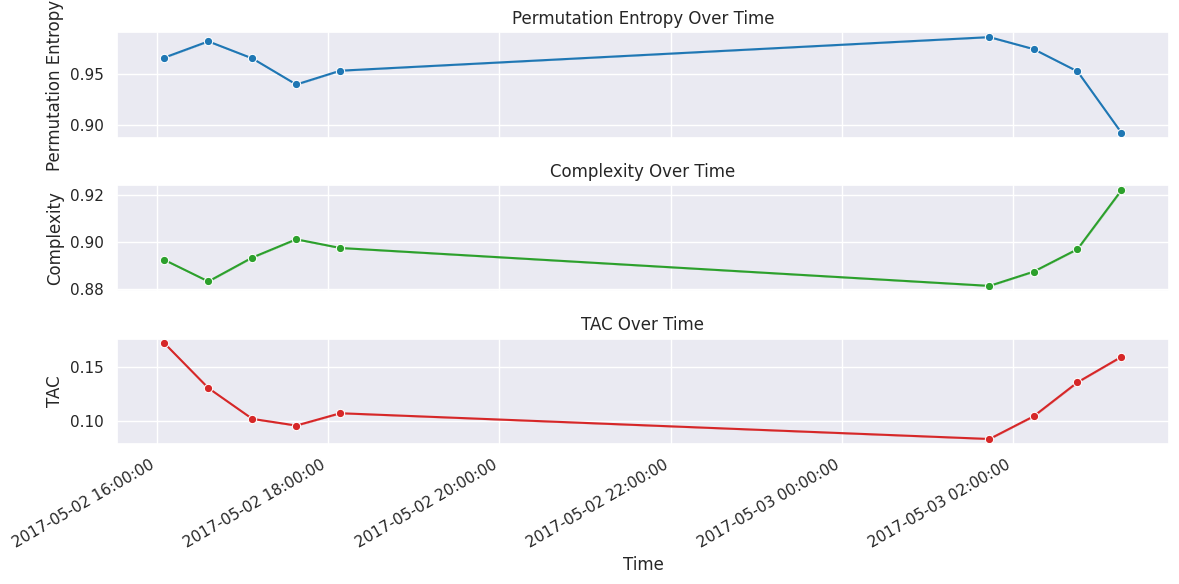

In [27]:
# Set the style
sns.set(style="darkgrid")

# Ensure 'time' is a datetime dtype if not already
df_pid['time'] = pd.to_datetime(df_pid['time'])

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

# Plot Permutation Entropy
sns.lineplot(ax=axs[0], data=df_pid, x='time', y='permutation_entropy', marker='o', color="tab:blue")
axs[0].set_title('Permutation Entropy Over Time')
axs[0].set_ylabel('Permutation Entropy')

# Plot Complexity
sns.lineplot(ax=axs[1], data=df_pid, x='time', y='complexity', marker='o', color="tab:green")
axs[1].set_title('Complexity Over Time')
axs[1].set_ylabel('Complexity')

# Plot TAC
sns.lineplot(ax=axs[2], data=df_pid, x='time', y='tac', marker='o', color="tab:red")
axs[2].set_title('TAC Over Time')
axs[2].set_ylabel('TAC')

# Set common labels and format the x-axis to display dates in 'YYYY-MM-DD HH:MM:SS' format
plt.xlabel('Time')
plt.gcf().autofmt_xdate() # Auto-format the x-axis labels to fit them better
date_format = DateFormatter("%Y-%m-%d %H:%M:%S")
axs[2].xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

Plot the permutation entropy, complexity and TAC reading for all pids.

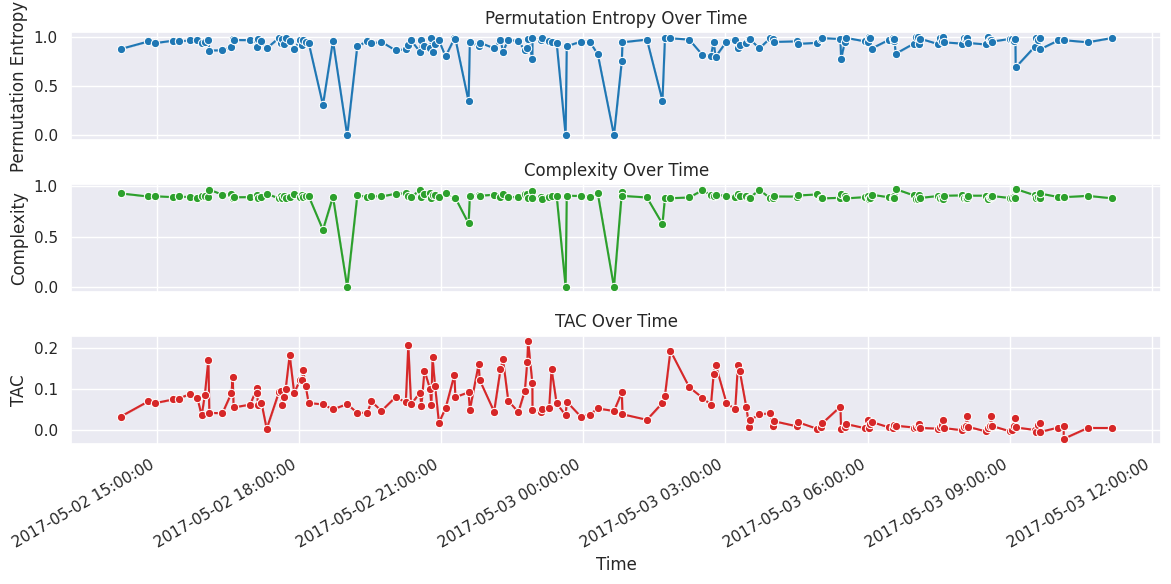

In [28]:
# Set the style
sns.set(style="darkgrid")

# Ensure 'time' is a datetime dtype if not already
df_sample_segmented['time'] = pd.to_datetime(df_sample_segmented['time'])

# Create a figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

# Plot Permutation Entropy
sns.lineplot(ax=axs[0], data=df_sample_segmented, x='time', y='permutation_entropy', marker='o', color="tab:blue")
axs[0].set_title('Permutation Entropy Over Time')
axs[0].set_ylabel('Permutation Entropy')

# Plot Complexity
sns.lineplot(ax=axs[1], data=df_sample_segmented, x='time', y='complexity', marker='o', color="tab:green")
axs[1].set_title('Complexity Over Time')
axs[1].set_ylabel('Complexity')

# Plot TAC
sns.lineplot(ax=axs[2], data=df_sample_segmented, x='time', y='tac', marker='o', color="tab:red")
axs[2].set_title('TAC Over Time')
axs[2].set_ylabel('TAC')

# Set common labels and format the x-axis to display dates in 'YYYY-MM-DD HH:MM:SS' format
plt.xlabel('Time')
plt.gcf().autofmt_xdate() # Auto-format the x-axis labels to fit them better
date_format = DateFormatter("%Y-%m-%d %H:%M:%S")
axs[2].xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

Plot Permutation Entropy vs Complexity for one pid.

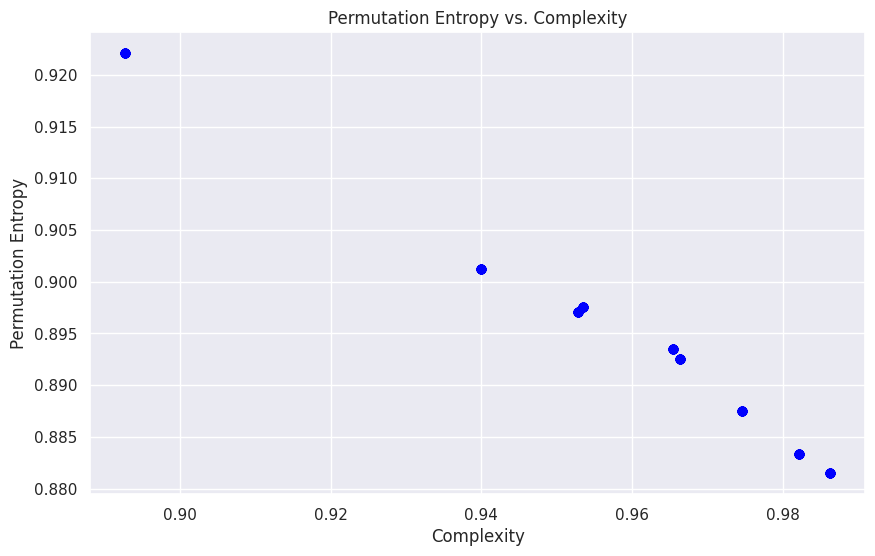

In [29]:
# Plotting Permutation Entropy vs. Complexity
plt.figure(figsize=(10, 6))
plt.scatter(df_pid['permutation_entropy'], df_pid['complexity'], color='blue', alpha=0.5)
plt.title('Permutation Entropy vs. Complexity')
plt.xlabel('Complexity')
plt.ylabel('Permutation Entropy')
plt.grid(True)
plt.show()


# Step 5 : Compare Permutation Entropy and Complexity with Tac values

Drinking level is calculated based on tac reading. As per the guideline, tac reading above 0.08 denotes 'intoxicated' and tac reading below 0.08 denotes 'sober'. A new column drinking level is created to denote the true value of 'drinking level'.

In [30]:
#Label the dataset based on tac
# Define the threshold for 'tac' above which subjects are considered "Intoxicated"
tac_threshold = 0.08

# Create a new column 'drinking_level' based on the 'tac' threshold
df_sample_segmented['drinking_level'] = df_sample_segmented['tac'].apply(lambda x: 'Intoxicated' if x > tac_threshold else 'Sober')
df_sample_segmented

,pid,time,resultant_vec,tac,segment_id,permutation_entropy,complexity,drinking_level
62,BK7610,2017-05-02 14:57:26,0.332943,0.065357,0,0.938443,0.899983,Sober
63,BK7610,2017-05-02 14:57:26,0.343604,0.065357,0,0.938443,0.899983,Sober
64,BK7610,2017-05-02 14:57:26,0.440437,0.065357,0,0.938443,0.899983,Sober
65,BK7610,2017-05-02 14:57:26,0.400427,0.065357,0,0.938443,0.899983,Sober
66,BK7610,2017-05-02 14:57:26,0.372569,0.065357,0,0.938443,0.899983,Sober
...,...,...,...,...,...,...,...,...
3851,SF3079,2017-05-03 03:15:46,0.136003,0.159026,8,0.892810,0.922106,Intoxicated
3852,SF3079,2017-05-03 03:15:46,0.233955,0.159026,8,0.892810,0.922106,Intoxicated
3853,SF3079,2017-05-03 03:15:46,0.244065,0.159026,8,0.892810,0.922106,Intoxicated
3854,SF3079,2017-05-03 03:15:46,0.166261,0.159026,8,0.892810,0.922106,Intoxicated


A classification model is created to identify the intoxication level based on permutation entropy and complexity. It is evaluated against the true value using TAC reading.

In [31]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report

# Assuming df_sample_segmented['drinking_level'] has been created based on the tac values

# Encode the 'drinking_level' labels into numeric form
encoder = LabelEncoder()
df_sample_segmented['drinking_level_encoded'] = encoder.fit_transform(df_sample_segmented['drinking_level'])


# Define features and target
X = df_sample_segmented[['permutation_entropy', 'complexity']]
y = df_sample_segmented['drinking_level_encoded']

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(X, y)

# Predicting the drinking_level using the model
y_pred = model.predict(X)

# Calculating accuracy and precision
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average=None)  # Use average='binary' for binary classification if needed

# Generating a classification report
report = classification_report(y, y_pred, target_names=encoder.classes_)

# Displaying the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(report)

Accuracy: 0.7200260289572149
Precision: [0.62962963 0.72082718]
              precision    recall  f1-score   support

 Intoxicated       0.63      0.02      0.04      1735
       Sober       0.72      1.00      0.84      4412

    accuracy                           0.72      6147
   macro avg       0.68      0.51      0.44      6147
weighted avg       0.70      0.72      0.61      6147



# Summary
The accuracy of the classification model is 72%, which means when the model tries to predict whether someone is "Intoxicated" or "Sober" based on permutation_entropy and complexity, it gets it right 72 times out of 100.
We see that it can identify the intoxication level as "Sober" correctly in most of the cases (72%), but the identification of "Intoxication" is 63%. Although there are no thresholds or measurements for permutation entropy or complexity for intoxication levels, these measures are not comprehensive enough to confirm that these indicators can be used to measure the intoxication levels. But it gives an overall idea that permutation entropy and complexity have some correlation on the toxication levels.